In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
os.environ['https_proxy'] = 'http://10.16.35.10:13390' 

import torch
from torch import nn
import torch.nn.functional as F

import sys
sys.path.append('..')
from prior_networks import UViT_Clip
from prior_pipe import PriorPipe
from dataset import *
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load prior diffusion

In [2]:
diffusion_prior = UViT_Clip(embed_dim=512, num_heads=8, mlp_ratio=4)
# number of parameters
sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad)
pipe = PriorPipe(diffusion_prior, device=device)
# load pretrained model
model_name = 'uvit_vice_pred_imagenet' 
path = f'../ckpts/{model_name}'
pipe.diffusion_prior.load_state_dict(torch.load(f'{path}.pt'))
# pipe.ema.load_state_dict(torch.load(f'{path}_ema.pt'))

<All keys matched successfully>

# load sd

In [3]:
# extract image features
from diffusers.utils import load_image
from IPython.display import Image, display
from customized_pipe import Generator4Embeds, encode_image
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
import torch

feature_extractor = CLIPImageProcessor()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter", 
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
).to("cuda")

pipe_image = Generator4Embeds(path='stabilityai/sdxl-turbo', num_inference_steps=4)
# pipe_image = Generator4Embeds(path='stabilityai/stable-diffusion-xl-base-1.0', num_inference_steps=25)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
pipe_image.pipe.feature_extractor = feature_extractor
pipe_image.pipe.image_encoder = image_encoder

In [5]:
from diffusers.schedulers import DDPMScheduler
scheduler = DDPMScheduler(
    thresholding=False,
    clip_sample=False,
)
pipe.scheduler = scheduler
print((
    pipe.scheduler.config.thresholding, 
    pipe.scheduler.config.sample_max_value, 
    pipe.scheduler.config.clip_sample,
    pipe.scheduler.config.clip_sample_range
))

(False, 1.0, False, 1.0)


# load concept encoder

In [6]:
# Load concept encoder
from networks import SimpleRegProb
# concept_encoder = MLPProb(1024, 42, l1=0.01).to(device)
concept_encoder = SimpleRegProb(1024, 42, l1=0).to(device)
path_save = os.path.join('../ckpts', 'emb_predict_SimpleReg.pt')
concept_encoder.load_state_dict(torch.load(path_save)['parameters'])

<All keys matched successfully>

In [7]:
from diffusers.utils import load_image, make_image_grid

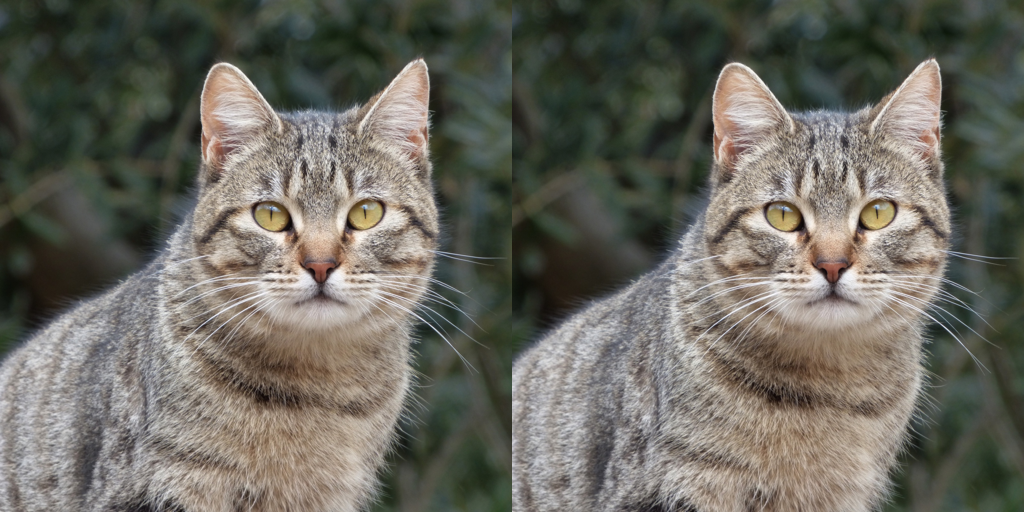

In [8]:
# extract a concept embedding
image_prompt = load_image("../images/cat.jpg")
image_prompt2 = load_image("../images/cat.jpg")
# image_prompt = load_image("https://image-cdn.hypb.st/https%3A%2F%2Fhypebeast.com%2Fwp-content%2Fblogs.dir%2F6%2Ffiles%2F2022%2F10%2Fstudio-ghibli-hayao-miyazaki-new-movie-almost-finished-1.jpg?cbr=1&q=90")
from IPython.display import display
image_embeds = encode_image([image_prompt, image_prompt2], image_encoder, feature_extractor)
concept_embeds = concept_encoder(image_embeds.float())   
display(make_image_grid([image_prompt, image_prompt2], rows=1, cols=2, resize=512))

# Experiments

In [9]:
property_features = torch.load(os.path.join('../ckpts', 'property_features.pt'))
word_emb = property_features['text_features']
word_list = property_features['text']
label_concept = torch.load(os.path.join('../ckpts', 'label_dim.pt'))

# Fig1: Smooth changes based on concepts (control ci + sim 8*8)

In [12]:
# concept_edited = ['many colors', 'plant']
# values = torch.tensor([[1.6-i*0.2, 0.5+i*0.2] for i in range(num)], device=device)
# seed_value = 0

# concept_edited = ['wood', 'cotton clothing']
# values = torch.tensor([[2.-i*0.1, 1+i*0.1] for i in range(num)], device=device)
# seed_value = 4

# concept_edited = ['ground animals']
# values = torch.tensor([[2.5-i*0.3] for i in range(num)], device=device)
# seed_value = 1

# concept_edited = ['cotton clothing', 'outdoor objects', 'ground animals']
# values = torch.tensor([[1.8-i*0.2, 1.-i*0., 0.5+i*0.2] for i in range(num)], device=device)

In [13]:
concept_edited = ['containers for liquids']
num = 16
values = torch.tensor([[i*0.1] for i in range(num)], device=device)
seed_value = 0
ind_concept_edited = [label_concept.index(c) for c in concept_edited]

generators = [torch.Generator(device=device).manual_seed(1) for _ in range(num)]
for generator in generators:
    generator.manual_seed(seed_value)

from guidance_set import get_loss_dim, get_loss_smooth, fns_collector
# Adjust loss functions to handle batched input
loss_dim = get_loss_dim(concept_encoder, ind_concept_edited, values)
loss_sim = get_loss_smooth(n_diag=2, threshold=1.0)

loss_func = fns_collector(
    fns=[loss_dim, loss_sim],
    scales=[10, 5]
)

with torch.no_grad():
    # Generate all embeddings in one pass
    h = pipe.generate_guidance(
        loss_fn=loss_func,
        num_inference_steps=50,
        num_resampling_steps=5,
        guidance_scale=0.5,
        generator=generators,
        use_ema=False,
        latent=None,
        strength=1,
        N=num,
        shape=(1024,)
    )
    # Generate all images in parallel
    pipe_image.pipe.set_ip_adapter_scale(1)
    text_prompt = 'well-formed, beautiful, correct proportions, high resolution, good anatomy, best quality, high quality.'
    negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

    # from diffusers import AutoPipelineForImage2Image
    # pipe_image.pipe = AutoPipelineForImage2Image.from_pipe(pipe_image.pipe).to("cuda")
    # images = []
    # for i in range(num):
    #     generators[i].manual_seed(seed_value)
    #     image = pipe_image.generate(
    #         h[i:i+1].to(dtype=torch.float16),
    #         image=image_prompt2.resize((512, 512)),
    #         strength=1, 
    #         # text_prompt=text_prompt,
    #         # negative_prompt=negative_prompt,
    #         generator=generators[i],
    #         # guidance_scale=5,
    #     )
    #     images.append(image[0])
    # pipe_image.pipe = AutoPipelineForText2Image.from_pipe(pipe_image.pipe).to("cuda")

    # images = pipe_image.generate(
    #     h.to(dtype=torch.float16),
    #     # image=8*[image_prompt2],
    #     # strength=0.5, 
    #     # text_prompt=text_prompt,
    #     # negative_prompt=negative_prompt,
    #     generator=generators,
    #     # guidance_scale=5,
    # )
    images = []
    for i in range(num):
        generators[i].manual_seed(seed_value)
        image = pipe_image.generate(
            h[i:i+1].to(dtype=torch.float16),
            # image=image_prompt.resize((512, 512)),
            # strength=0.5, 
            # text_prompt=text_prompt,
            # negative_prompt=negative_prompt,
            generator=generators[i],
            # guidance_scale=5,
        )
        images.append(image[0])

50it [00:05,  9.33it/s]
/home/weichen/miniconda3/envs/sd/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `_name_or_path` directly via 'StableDiffusionXLPipeline' object attribute is deprecated. Please access '_name_or_path' over 'StableDiffusionXLPipeline's config object instead, e.g. 'scheduler.config._name_or_path'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

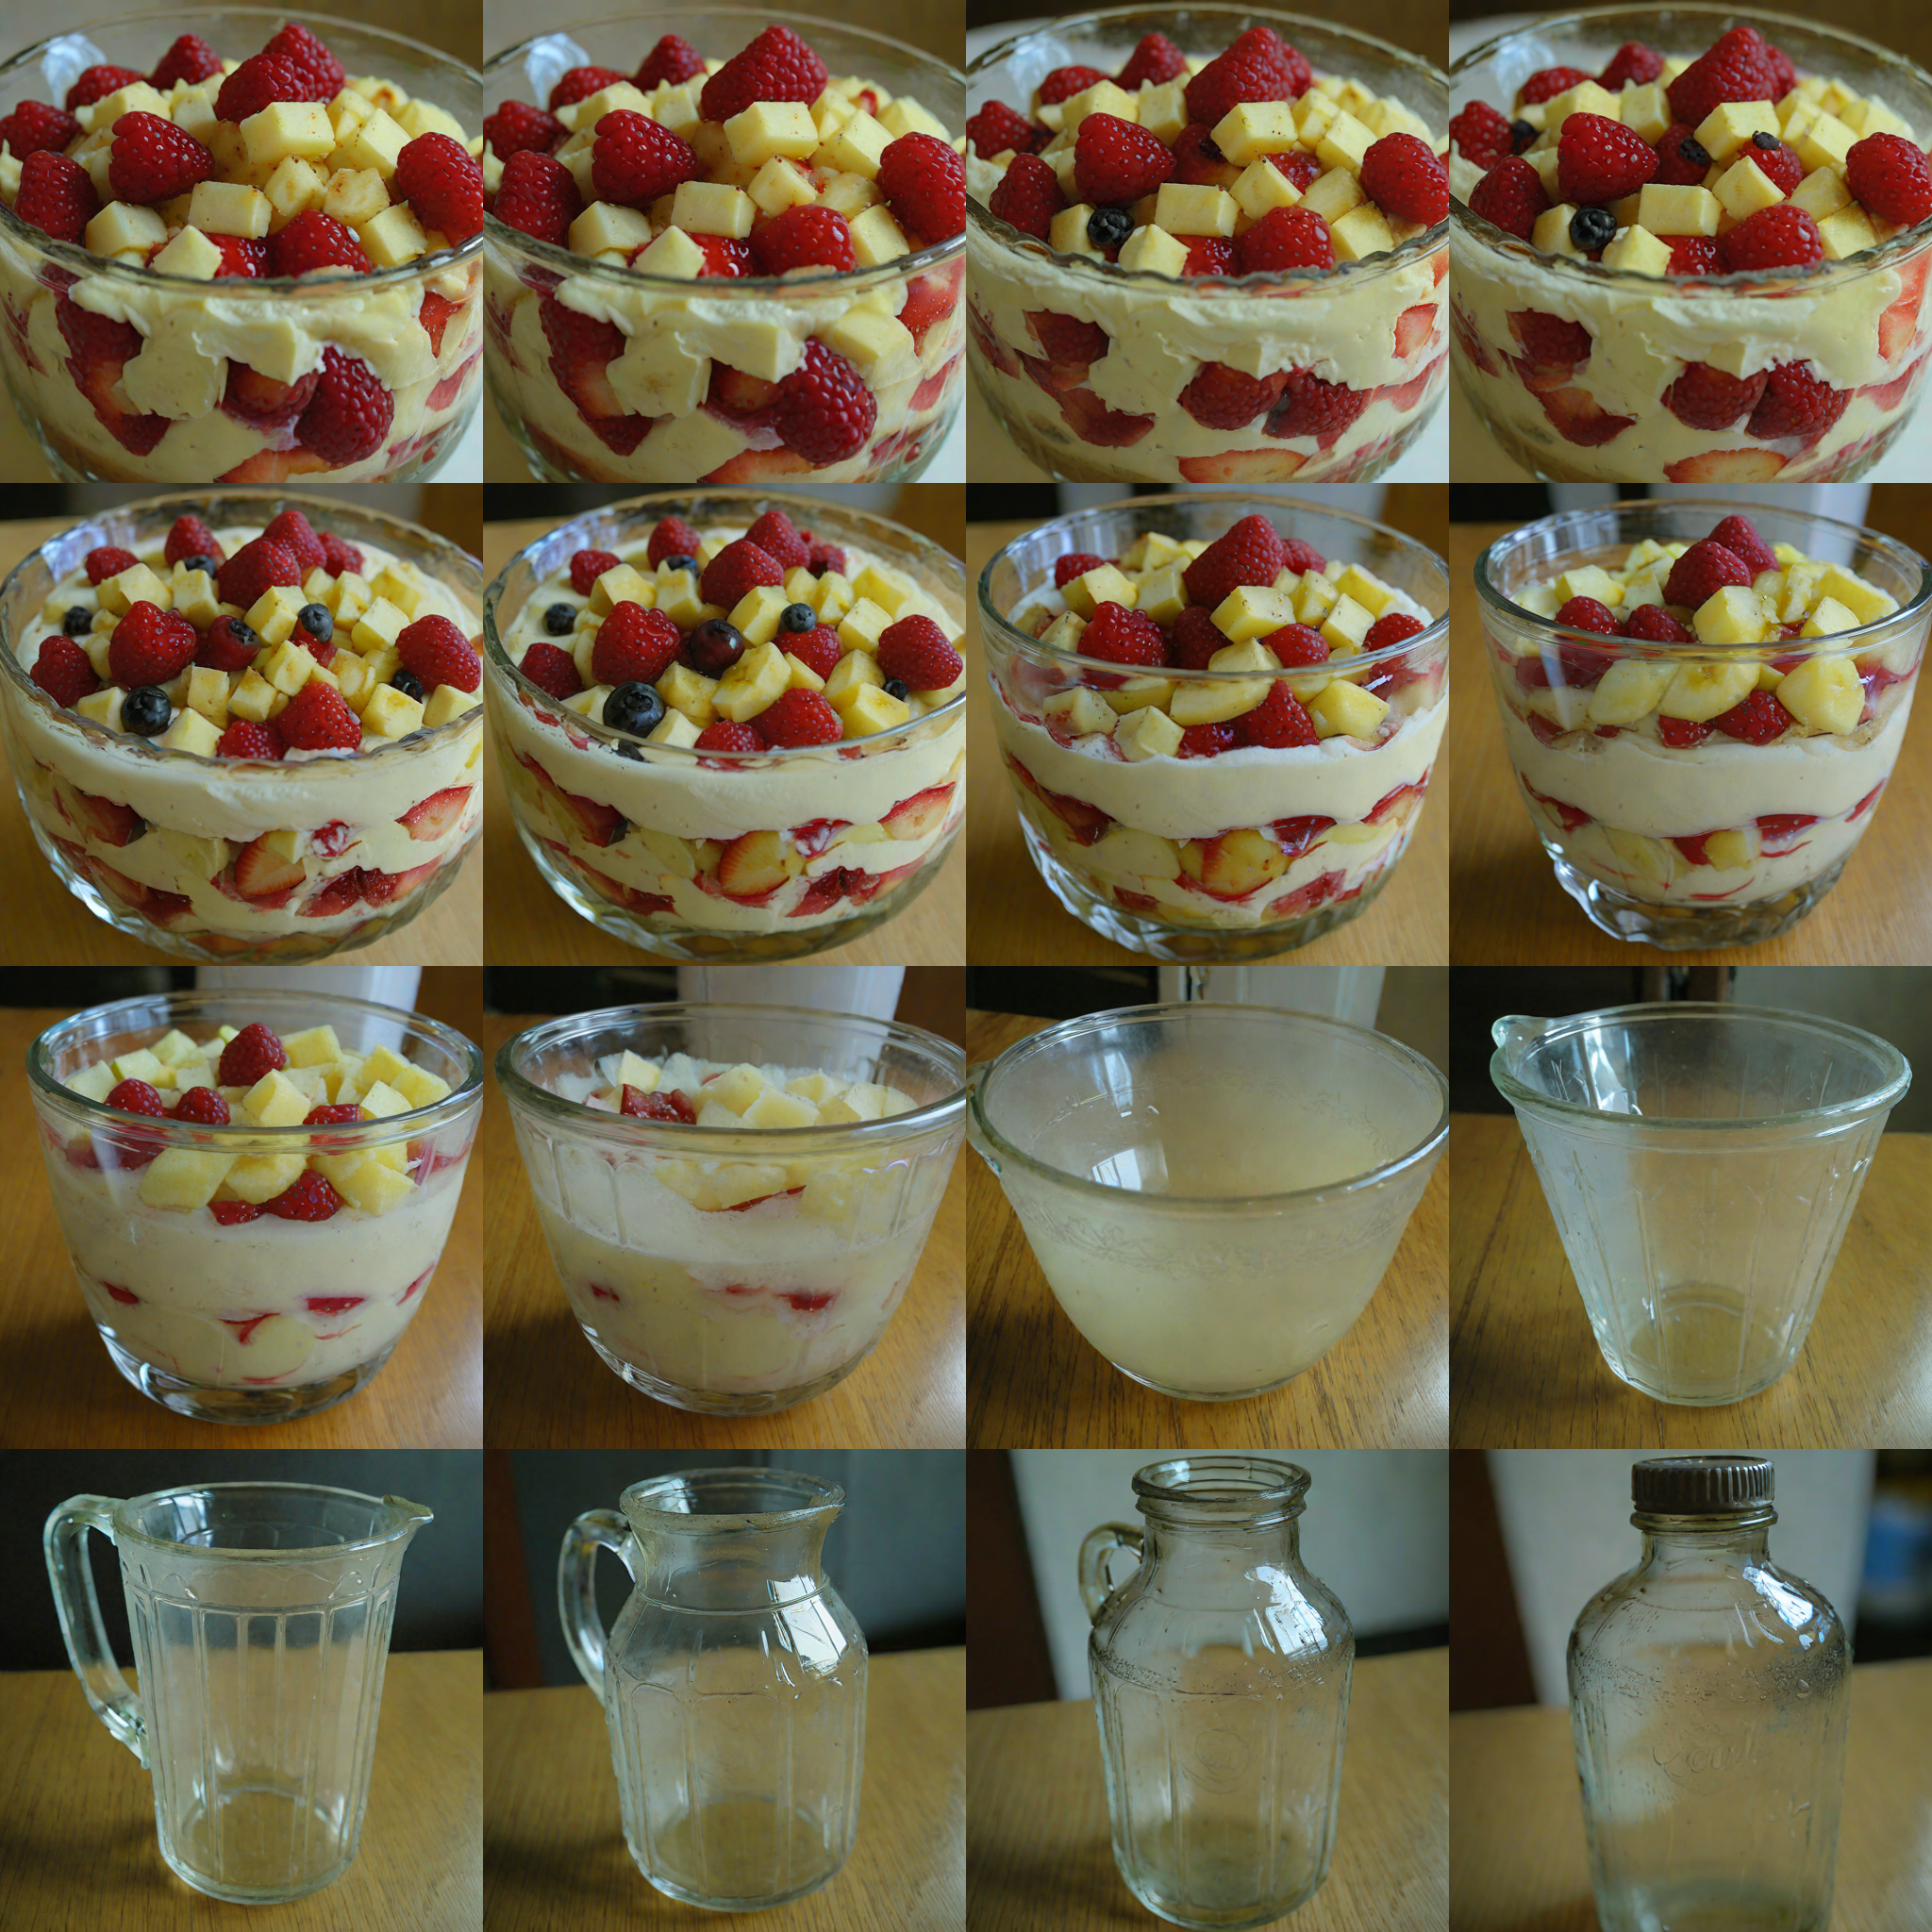

In [14]:
# from diffusers.utils import make_image_grid
display(make_image_grid(images, rows=4, cols=4, resize=512))

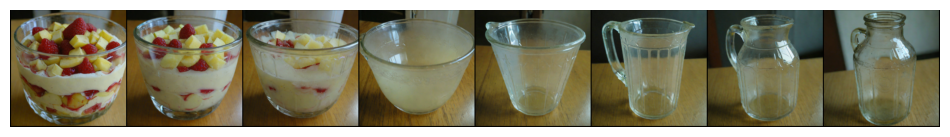

In [16]:
plot_indices_grid([images[6],*images[8:15]], shape=(1,8))

In [ ]:
# images = [images[7:15]]
# h = h[7:15]

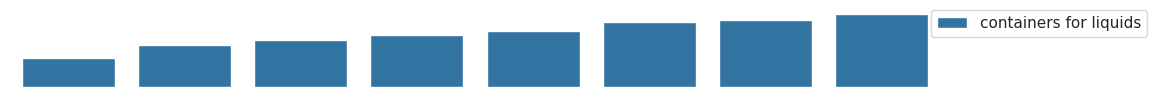

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

xticks = list(range(8))
num = [6,8,9,10,11,12,13,14]

# image_embeds_pred = encode_image(images, image_encoder, feature_extractor)
concept_embeds_h = concept_encoder(h[num].float()) 
# concept_embeds_pred = concept_encoder(image_embeds_pred.float()) 
# values of the concept edited across the batch
## (B, len(concept_dims))
values_gen = concept_embeds_h[:, ind_concept_edited].detach().cpu()
values_gen = values_gen.tolist()

# create df for barplot, with xticks, value and concept
df = pd.DataFrame({'xticks': [i for i in xticks for _ in range(1)], 'value': [i for v in values_gen for i in v], 'concept': concept_edited*8})

# 创建折线图
sns.set(style="whitegrid")  # 设置Seaborn样式

plt.figure(figsize=(12, 1.))

# 绘制折线图
ax = sns.barplot(x='xticks', y='value', hue='concept', data=df, palette="tab10")



sns.despine(left=True, bottom=True)  # 移除左边和底部的轴线和边框

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

plt.legend(bbox_to_anchor=(0.99,1), loc=2, borderaxespad=0.)
plt.show()

50it [00:03, 12.72it/s]
50it [00:04, 12.07it/s]
50it [00:04, 12.48it/s]
50it [00:04, 12.19it/s]
50it [00:03, 12.55it/s]
50it [00:04, 11.53it/s]
50it [00:04, 12.09it/s]
50it [00:04, 11.08it/s]
50it [00:04, 11.19it/s]
50it [00:04, 10.91it/s]


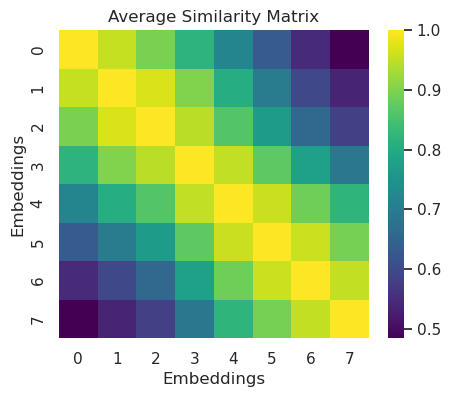

In [ ]:
num = 8
concept_edited = ['cotton clothing', 'outdoor objects', 'ground animals']
values = torch.tensor([[1.8-i*0.2, 1.6-i*0.2, 0.5+i*0.2] for i in range(num)], device=device)
ind_concept_edited = [label_concept.index(c) for c in concept_edited]
n_generations = 10  # Number of generations to average over

# Adjust loss functions for batch input
loss_dim = get_loss_dim(concept_encoder, ind_concept_edited, values)
loss_sim = get_loss_sim(n_diag=3)
loss_func = fns_collector(fns=[loss_dim, loss_sim], scales=[10, 1])

# Prepare to accumulate similarity matrices
sim_accumulate = torch.zeros((num, num), device=device)

for i in range(n_generations):
    seed_value = i
    # Prepare generators
    generators = [torch.Generator(device=device).manual_seed(seed_value) for _ in range(num)]
    for generator in generators:
        generator.manual_seed(seed_value)
        # Generate embeddings
    h = pipe.generate_guidance(
        loss_fn=loss_func,
        num_inference_steps=50,
        num_resampling_steps=5,
        guidance_scale=0.5,
        generator=generators,
        use_ema=False,
        latent=None,
        strength=1,
        N=num,
        shape=(1024,)
    )
    # Normalize the embeddings to unit length
    h_norm = h / h.norm(dim=1, keepdim=True)

    # Calculate the similarity matrix as the dot product of normalized embeddings
    sim = torch.mm(h_norm, h_norm.t())

    # Accumulate the similarity matrices
    sim_accumulate += sim

# Compute the average similarity matrix
average_sim = sim_accumulate / (n_generations)

# Convert the average similarity matrix to a numpy array for visualization
average_sim_np = average_sim.detach().cpu().numpy()

# Visualize the average similarity matrix using seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(average_sim_np, cmap='viridis')
plt.title('Average Similarity Matrix')
plt.xlabel('Embeddings')
plt.ylabel('Embeddings')
plt.show()